### 05_cnn_sentence_classification_20

In [1]:
# url = 'http://cogcomp.org/Data/QA/QC/'
# dir_name = 'question-classif-data'

# def maybe_download(dir_name, filename, expected_bytes):
#   """Download a file if not present, and make sure it's the right size."""
#   if not os.path.exists(dir_name):
#         os.mkdir(dir_name)
#   if not os.path.exists(os.path.join(dir_name,filename)):
#     filename, _ = urlretrieve(url + filename, os.path.join(dir_name,filename))
#   print(os.path.join(dir_name,filename))
#   statinfo = os.stat(os.path.join(dir_name,filename))
#   if statinfo.st_size == expected_bytes:
#     print('Found and verified %s' % os.path.join(dir_name,filename))
#   else:
#     print(statinfo.st_size)
#     raise Exception(
#       'Failed to verify ' + os.path.join(dir_name,filename) + '. Can you get to it with a browser?')
#   return filename

# filename = maybe_download(dir_name, 'train_1000.label', 60774)
# test_filename = maybe_download(dir_name, 'TREC_10.label',23354)

In [59]:
import os

url = 'http://cogcomp.org/Data/QA/QC/'
data_dir = os.path.join(".","data","question-classif-data")
filename = 'train_1000.label'
test_filename = 'TREC_10.label'

filenames = ['train_1000.label','TREC_10.label']
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(data_dir,filenames[i]))
    if file_exists:
        print(filenames[i],"Exist")
    else:
        print("download file")
        # maybe_downlaod

batch_size = 128 # We process 16 questions at a time
all_labels = []
with open(os.path.join(data_dir,filename)) as f:
    for line in f.readlines():
        content = line.split(":")
        if content[0] not in all_labels:
            all_labels.append(content[0])
            
print(all_labels)

train_1000.label Exist
TREC_10.label Exist
['DESC', 'ENTY', 'ABBR', 'HUM', 'NUM', 'LOC']


In [60]:
max_sent_length = 0 #問句中最長陣列的句子長度
questions = []
labels = []

with open(os.path.join(data_dir,filename),"r",encoding="latin-1") as f:
    for line in f:
        content = line.split(":")
        label, question = content[0],content[1]
        question = question.lower().split()
        questions.append(question)
        labels.append(label)
        if len(question) > max_sent_length:
            max_sent_length= len(question)
print("questions",len(questions),"labels",len(labels))
print("max_sent_length",max_sent_length)
print("quest",questions[13])
print("label",labels[13])
temp_label = labels[13]
from tensorflow.keras import utils
label_dict = dict()
for i in range(len(all_labels)):
    label_dict[all_labels[i]] = i    
print(label_dict)

labels = [label_dict[label] for label in labels]
labels = utils.to_categorical(labels)
print(temp_label)
print("label",labels[13])

questions 1000 labels 1000
max_sent_length 33
quest ['ind', 'who', 'killed', 'gandhi', '?']
label HUM
{'DESC': 0, 'ENTY': 1, 'ABBR': 2, 'HUM': 3, 'NUM': 4, 'LOC': 5}
HUM
label [0. 0. 0. 1. 0. 0.]


In [61]:
import collections
from tensorflow.keras.preprocessing import sequence

words = []
count = []
data = []
for sent in questions:
    words.extend(sent)
print('%d Words found.'%len(words))  
count.extend(collections.Counter(words).most_common())
vocab_size = len(count) + 1
print('Found %d words in the vocabulary. '%vocab_size)
dictionary = dict()
dictionary["PAD"] = len(dictionary)
for word, _ in count:
    dictionary[word] = len(dictionary)
    
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

for sent in questions:
    sent_idx = list()
    for word in sent:
        index = dictionary[word]
        sent_idx.append(index)
    data.append(sent_idx)
data = sequence.pad_sequences(data, padding='post')
print("data shape",data.shape)

10835 Words found.
Found 2773 words in the vocabulary. 
data shape (1000, 33)


In [62]:
index = 13
for word in data[index]:
    print("%s(%d)"%(reverse_dictionary[word],word), end=" ")

ind(7) who(13) killed(145) gandhi(793) ?(1) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) PAD(0) 

In [63]:
from tensorflow.keras import layers, models, optimizers
from tensorflow import keras

embed_dim = 128

inputs = keras.Input(shape=(max_sent_length,))
d = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
d = layers.LSTM(units=embed_dim, dropout=0.2, recurrent_dropout=0.2)(d)
outputs = layers.Dense(units=len(all_labels), activation="softmax")(d)
model = models.Model(inputs, outputs)
model.summary()

optimizer = optimizers.Adam()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 33)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 33, 128)           354944    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 487,302
Trainable params: 487,302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
_data = []
_labels = []
for i in range(len(data)//batch_size):    
    _data.append(data[i*batch_size:(i+1)*batch_size])
    _labels.append(labels[i*batch_size:(i+1)*batch_size])

In [145]:
import tensorflow as tf

@tf.function
def compute_loss(logits, labels):
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    #print("loss",loss)
    return tf.reduce_mean(loss)

@tf.function
def compute_accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1)
    labels = tf.argmax(labels, axis=1)
    #print("predictions",predictions)
    #print("labels",labels)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))

@tf.function
def train_one_step(model, optimizer, x, y):    
    with tf.GradientTape() as tape:
        logits = model(x)
        #print("logits",logits)
        #print("y",y)
        loss = compute_loss(logits, y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    accuracy = compute_accuracy(logits, y)
    
    return loss, accuracy

train_accuracy_over_time = []
train_loss_over_time = []

def train(epoch, model, optimizer):
    loss = 0.0
    accuracy = 0.0
    total_step = 0
    for step, (x,y) in enumerate(zip(_data,_labels)):            
        total_step += 1
        loss, accuracy = train_one_step(model, optimizer, x, y)
        if (step+1) % 3 == 0:
            train_loss_over_time.append(loss.numpy())
            train_accuracy_over_time.append(accuracy.numpy())
            print('epoch', epoch,"step",(step+1), ': loss', loss.numpy(), '; accuracy', accuracy.numpy())
    print("total_step",total_step)
    return loss, accuracy

for epoch in range(3):
    loss, accuracy = train(epoch, model, optimizer)
print('Final epoch', epoch, ': loss', loss.numpy(), '; accuracy', accuracy.numpy())
    

epoch 0 step 3 : loss 1.5584677 ; accuracy 0.484375
epoch 0 step 6 : loss 1.5766143 ; accuracy 0.4375
total_step 7
epoch 1 step 3 : loss 1.5569447 ; accuracy 0.484375
epoch 1 step 6 : loss 1.571444 ; accuracy 0.4375
total_step 7
epoch 2 step 3 : loss 1.5639052 ; accuracy 0.484375
epoch 2 step 6 : loss 1.5770938 ; accuracy 0.4375
total_step 7
Final epoch 2 : loss 1.4898777 ; accuracy 0.546875


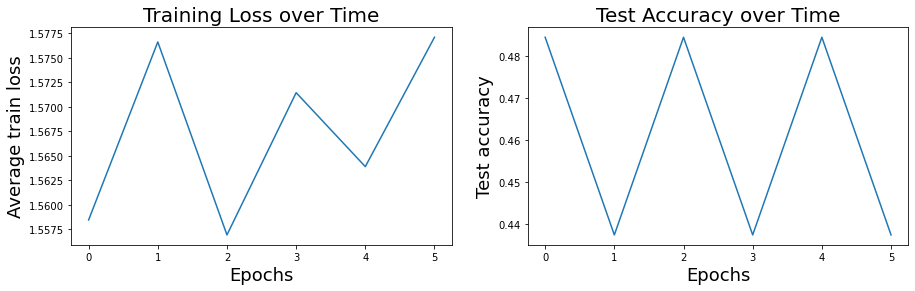

In [146]:
import matplotlib.pyplot as plt
x_axis = np.arange(len(train_loss_over_time))

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=15,h=4)
ax[0].plot(x_axis, train_loss_over_time)
ax[0].set_xlabel('Epochs',fontsize=18)
ax[0].set_ylabel('Average train loss',fontsize=18)
ax[0].set_title('Training Loss over Time',fontsize=20)
ax[1].plot(x_axis, train_accuracy_over_time)
ax[1].set_xlabel('Epochs',fontsize=18)
ax[1].set_ylabel('Test accuracy',fontsize=18)
ax[1].set_title('Test Accuracy over Time',fontsize=20)
plt.show()
#fig.savefig('mnist_stats.jpg')

In [151]:
import numpy as np
index = 13
test_data = data[index:index+10]
test_labels = labels[index:index+10]
preds = model.predict(test_data)
test_labels = np.argmax(test_labels, axis=1)
preds = np.argmax(preds, axis=1)

print("labels",test_labels)
print("preds ",preds)

labels [3 1 5 0 4 0 0 4 1 3]
preds  [3 1 1 1 3 1 1 1 1 3]
